In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
session = tf.Session(config=config)

In [3]:
tf.__version__

'1.8.0'

### 定义神经网络所需要的基本参数

In [4]:
# 第一层卷积层的卷积核大小
filter_size1 = 5
# 第一层卷积核的个数
num_filters1 = 16
# 第二层卷积核的大小
filter_size2 = 5
# 第二层卷积核的大小
num_filter2 = 36
# 全连接层的大小
fc_size = 128

### 载入MNIST 数据集

In [5]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [6]:
# 查看数据集的大小
print("训练集的大小：", data.num_train)
print("验证集的大小:", data.num_val)
print("测试集的大小:", data.num_test)

训练集的大小： 55000
验证集的大小: 5000
测试集的大小: 10000


### 复制数据维度信息

In [7]:
# 图片展开的大小
img_size_flat = data.img_size_flat

#图片原始尺寸
img_shape = data.img_shape

# 类别数
num_classes = data.num_classes

#每个维度上图片的像素个数
img_size = data.img_size

# 图片的通道数
num_channels = data.num_channels

### Tensorflow图简单说明
- 占位符变量(placeholder)用来改变图的输入
- 模型变量(Model)将会被优化，使得模型的表现更好
- 模型本质上就是一些数学函数，它根据placeholder和模型的输入变量来计算一些输出
- 一个cost度量用来指导变量的优化
- 一个优化策略会更新模型的变量

### 创建新变量的帮助函数

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [9]:
tf.truncated_normal??

In [10]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [11]:
tf.constant??

### 创建卷积层的帮助函数

假设输入的四维张量，各个维度如下

1.图像数量 

2.每张图像的Y轴 

3.每张图像的X轴 

4.每张图像的通道数 


输入图片的张量的时候可能是彩色的通道即红绿蓝，当输入是前一层卷积层生成的输出的时候，它可能是滤波通道

输出是另外一个四通道的张量，如下
1.图像数量，与输入相同 

2.每张图的Y轴，如果用了2x2的池化，则输入是图像宽高的一半 

3.每张图像的X轴 

4.卷积滤波生成的通道数 


In [12]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    # 定义输入张量的形状
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    # 初始化当前层的weights
    weights = new_weights(shape=shape)
    # 初始化biases
    biases = new_biases(length=num_filters)
    # 建立一个卷积
    layer = tf.nn.conv2d(
        input=input,
        filter=weights,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )
    layer += biases
    if use_pooling is True:
        # 进行池化层操作
        # 初始化参数为： 输入层、卷积核大小2x2，步长高宽2，2，填充0
        layer = tf.nn.max_pool(
            value=layer,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='SAME'
        )
    # 对卷积的输出或池化层进行激活
    layer = tf.nn.relu(layer)
    return layer, weights
    

In [13]:
tf.reshape??

### 转换一个层的帮助函数

卷积层生成四维的张量，我们会在卷积层后添加一个全连接层，将这个四维张量转换为2维张量

In [14]:
def flatten_layer(layer):
    # 获取layer的shape
    layer_shape = layer.get_shape()
    # layer_shape = [num_images, img_height, img_width, num_channels]
    # 根据维度计算参数个数
    num_features = layer_shape[1:4].num_elements()
    # 展平张量 reshape 其中一个维度设置为-1 表示自动计算剩余的维度
    layer_flat = tf.reshape(layer, shape=[-1, num_features])
    return layer_flat, num_features

### 创建一个全连接层的帮助函数
输入大小是\[num_images, num_inputs\],输出大小是\[num_images, num_outputs\]

In [15]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu is True:
        layer = tf.nn.relu(layer)
    return layer

### 声明占位符变量

In [16]:
# mnist输入图像的大小为多张 形状为img_size_flat大小的向量
x = tf.placeholder(dtype=tf.float32, shape=[None, img_size_flat], name='x')
# 卷积层接受的是[image_num, image_height, image_width, num_channels]的四维张量，需要用reshape进行变换
x_image = tf.reshape(x, shape=[-1, img_size, img_size, num_channels])
# 定义真实类别
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name="y_true")
# sparse 真实类别
y_true_cls = tf.argmax(y_true, axis=1)

### 定义第一个卷积层

In [17]:
layer1, weights1 = new_conv_layer(
    input=x_image, 
    num_input_channels=num_channels, 
    filter_size=filter_size1, 
    num_filters=num_filters1, 
    use_pooling=True
)

In [47]:
weights1

<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>

### 定义第二个卷积层

In [19]:
layer2, weights2 = new_conv_layer(
    input=layer1,
    num_input_channels=num_filters1,
    filter_size=filter_size2,
    num_filters=num_filter2,
    use_pooling=True
)

In [48]:
weights2

<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>

### 将卷积层展平

In [21]:
layer_flat, num_features = flatten_layer(layer2)

### 建立全连接层1
输出为128维向量

In [22]:
layer_fc1 = new_fc_layer(
    input=layer_flat, 
    num_inputs=num_features, 
    num_outputs=fc_size, 
    use_relu=True
)

In [49]:
num_features

1764

### 建立全连接层2
输出为num_classes

In [24]:
layer_fc2 = new_fc_layer(
    input=layer_fc1,
    num_inputs=fc_size,
    num_outputs=num_classes,
    use_relu=False
)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [26]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### 建立损失函数对logits进行损失计算

In [27]:
# 总体的损失估计
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)
# 利用平均损失估计进行度量
cost = tf.reduce_mean(cross_entropy)

### 建立优化方法进行优化

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### 性能度量

In [59]:
y_pred_cls = tf.argmax(tf.nn.softmax(layer_fc2), axis=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [60]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

## TODO
1.复习建模的整个流程：初始化变量-》建模-》建立损失函数-》建立优化器-》建立性能评估

2.复习卷积层、池化层、激活函数的参数用法

### 创建Tensorflow会话

In [31]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### 定义优化的帮助函数

In [63]:
train_batch_size = 64
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)
        session.run(optimizer, feed_dict={x:x_batch, y_true:y_true_batch})
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict={x:x_batch, y_true:y_true_batch})
            print("Optimization Iteration:{0:>6}, Training Accuracy: {1:>6.1%}".format(i, acc))
    total_iterations += num_iterations
    end_time = time.time()
    time_diff = end_time - start_time
    print("Time usage:", timedelta(seconds=int(round(time_diff))))

### 定义绘制错误预测样本的帮助函数

In [33]:
def plot_example_errors(cls_pred, correct):
    """
    cls_pred: 预测的类别编号
    correct： 预测正确和错误的bool列表
    """
    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test[incorrect]
    plot_images(images=images[0:9], cls_pred=cls_pred[0:9], cls_true=cls_true[0:9])

In [34]:
def plot_images(images, cls_pred, cls_true):
    """
    images: 图像列表
    cls_pred: 预测的类别
    cls_true:真实的类别
    """
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.set_xlabel("true:{0} pred:{1}".format(cls_true[i], cls_pred[i]))
        ax.imshow(images[i], cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### 绘制混淆矩阵帮助函数

In [35]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.y_test_cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### 利用测试集的数据进行性能评估

In [66]:
test_data_batch = 64
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = data.num_test
    cls_pred = np.zeros(shape=(num_test, ), dtype=np.int32)
    i = 0
    while i < num_test:
        # 这里 当i+test_data_batch 大于num_test的时候 j取值应该为num_test
        j = min(i+test_data_batch, num_test)
        test_batch_data = data.x_test[i:j, :]
        test_batch_label = data.y_test[i:j, :]
        feed_dict_test = {x:test_batch_data, y_true: test_batch_label}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict_test)
        i = j
    cls_true = data.y_test_cls
    correct = (cls_pred == cls_true)
    acc = float(correct.sum()) / num_test
    print("Accuracy:{0}".format(acc))
    if show_example_errors is True:
        plot_example_errors(cls_pred, correct)
    if show_confusion_matrix is True:
        plot_confusion_matrix(cls_pred)

In [64]:
# 执行优化
optimize(num_iterations=1000)

Optimization Iteration:     0, Training Accuracy:  67.2%
Optimization Iteration:   100, Training Accuracy:  84.4%
Optimization Iteration:   200, Training Accuracy:  84.4%
Optimization Iteration:   300, Training Accuracy:  85.9%
Optimization Iteration:   400, Training Accuracy:  90.6%
Optimization Iteration:   500, Training Accuracy:  89.1%
Optimization Iteration:   600, Training Accuracy:  96.9%
Optimization Iteration:   700, Training Accuracy:  95.3%
Optimization Iteration:   800, Training Accuracy:  95.3%
Optimization Iteration:   900, Training Accuracy:  89.1%
Time usage: 0:00:02


In [67]:
print_test_accuracy()

Accuracy:0.9313


Accuracy:0.9313
[[ 936    0   12    3    0    6   15    2    5    1]
 [   0 1116    4    2    0    1    4    0    8    0]
 [   5    1  976    8   10    0    6   11   13    2]
 [   1    4   17  947    0   10    1   12   11    7]
 [   0    2    5    0  919    0   10    3    4   39]
 [   7    5    6   40    7  784   21    1   17    4]
 [   5    4    6    1   11    9  920    1    1    0]
 [   0    9   41    4    4    0    0  928    1   41]
 [   5    7   11   33   11   21   10   10  853   13]
 [   5    6    9   12   14    4    0   18    7  934]]


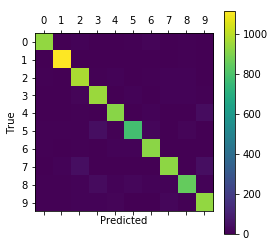

In [69]:
print_test_accuracy(show_confusion_matrix=True)